In [448]:
import os
import torch
print("Using torch", torch.__version__)

import torch_geometric
from torch_geometric.datasets import NELL, WikiCS, Wikidata5M
from torch_geometric import nn
import torch_geometric.transforms as T
from torch_geometric.utils import negative_sampling

Using torch 2.1.1


In [449]:
transform = T.Compose([
    T.RandomLinkSplit(num_val=0.05,  # ratio of edges including in the validation set
                      num_test=0.2,  # ratio of edges including in the test set
                      is_undirected=True,
                      add_negative_train_samples=False),
])

In [450]:
wikics_dataset = WikiCS("/Users/rohan/Documents/483FinalProject/tmp/wikics", transform=transform)
wikics_train, wikics_val, wikics_test = wikics_dataset[0]
print("WikiCS:")
print("\tNumber of the nodes in training, validation and test data are", wikics_train.num_nodes, wikics_val.num_nodes, wikics_test.num_nodes)
print("\tNumber of the edges in training, validation and test data are", wikics_train.num_edges, wikics_val.num_edges, wikics_test.num_edges)
print("\tNumber of the edge_label_index in training, validation and test data are", wikics_train.edge_label_index.shape[1],
                                                                                  wikics_val.edge_label_index.shape[1],
                                                                                  wikics_test.edge_label_index.shape[1])

WikiCS:
	Number of the nodes in training, validation and test data are 11701 11701 11701
	Number of the edges in training, validation and test data are 324186 324186 345798
	Number of the edge_label_index in training, validation and test data are 162093 21612 86448


/Users/rohan/miniconda3/envs/483proj/lib/python3.11/site-packages/torch_geometric/datasets/wikics.py:38: UserWarning: The WikiCS dataset now returns an undirected graph by default. Please explicitly specify 'is_undirected=False' to restore the old behavior.
  warnings.warn(


In [451]:
from torch_geometric.nn import SAGEConv

class GraphSAGE(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GraphSAGE, self).__init__()
        self.conv1 = SAGEConv(in_channels, hidden_channels)
        self.conv2 = SAGEConv(hidden_channels, out_channels)
        self.act = torch.nn.ReLU()

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = self.act(x)
        x = self.conv2(x, edge_index)
        return x

In [452]:
def compute_similarity(node_embs, edge_index):
    # Calculate the inner product between all the pairs in the edge_index
    # Note: the shape of node_embs is [n, h] where n is the number of nodes, and h is the embedding size
    # the shape of edge_index is [2, m] where m is the number of edges

    return torch.sum(node_embs[edge_index[0]] * node_embs[edge_index[1]], axis=1)

In [453]:
wikics_train

Data(x=[11701, 300], edge_index=[2, 324186], y=[11701], train_mask=[11701, 20], val_mask=[11701, 20], test_mask=[11701], stopping_mask=[11701, 20], edge_label=[162093], edge_label_index=[2, 162093])

In [454]:
def train(model, data, optimizer, loss_fn):

    loss = 0

    model.train() # 1

    optimizer.zero_grad() # 2

    node_rep = model(data.x, data.edge_index) # 3

    negative_edges = negative_sampling(
      edge_index=data.edge_label_index,  # positive edges in the graph
      num_nodes=data.num_nodes,  # number of nodes
      num_neg_samples=len(data.edge_label_index[0]),  # number of negative examples
    ) # 4

    all_edges = torch.cat((data.edge_label_index, negative_edges), 1) # 5

    all_labels = torch.cat((data.edge_label, data.edge_label-1)) # 6

    similarity = compute_similarity(node_rep, all_edges) # 7

    loss = loss_fn(similarity, all_labels)

    loss.backward() # 9

    optimizer.step() # 10

    return loss

In [455]:
from sklearn.metrics import roc_auc_score

@torch.no_grad()
def test(model, data):
    model.eval()
    out = model(data.x, data.edge_index)  # use `edge_index` to perform message passing
    out = compute_similarity(out, data.edge_label_index).view(-1).sigmoid()  # use `edge_label_index` to compute the loss
    return roc_auc_score(data.edge_label.cpu().numpy(), out.cpu().numpy())

In [456]:
emb_model = GraphSAGE(wikics_train.num_features, hidden_channels=128, out_channels=64)
emb_optimizer = torch.optim.Adam(params=emb_model.parameters(), lr=0.001)
emb_loss_fn = torch.nn.BCEWithLogitsLoss()

epochs = 200

best_val_auc = final_test_auc = 0
losses = []
valid_aucs = []
test_aucs = []
for epoch in range(1, epochs + 1):
    loss = train(emb_model, wikics_train, emb_optimizer, emb_loss_fn)
    valid_auc = test(emb_model, wikics_val)
    test_auc = test(emb_model, wikics_test)
    if valid_auc > best_val_auc:
        best_val_auc = valid_auc
        final_test_auc = test_auc
    losses.append(loss)
    valid_aucs.append(valid_auc)
    test_aucs.append(test_auc)
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Val: {valid_auc:.4f}, Test: {test_auc:.4f}')

Epoch: 001, Loss: 0.7045, Val: 0.7933, Test: 0.7923
Epoch: 002, Loss: 0.6903, Val: 0.8492, Test: 0.8463
Epoch: 003, Loss: 0.6858, Val: 0.8309, Test: 0.8260
Epoch: 004, Loss: 0.6805, Val: 0.8065, Test: 0.8003
Epoch: 005, Loss: 0.6749, Val: 0.7957, Test: 0.7894
Epoch: 006, Loss: 0.6708, Val: 0.7996, Test: 0.7939
Epoch: 007, Loss: 0.6641, Val: 0.8119, Test: 0.8070
Epoch: 008, Loss: 0.6540, Val: 0.8267, Test: 0.8226
Epoch: 009, Loss: 0.6445, Val: 0.8362, Test: 0.8329
Epoch: 010, Loss: 0.6338, Val: 0.8389, Test: 0.8359
Epoch: 011, Loss: 0.6211, Val: 0.8393, Test: 0.8363
Epoch: 012, Loss: 0.6080, Val: 0.8429, Test: 0.8400
Epoch: 013, Loss: 0.5958, Val: 0.8491, Test: 0.8465
Epoch: 014, Loss: 0.5824, Val: 0.8507, Test: 0.8486
Epoch: 015, Loss: 0.5707, Val: 0.8492, Test: 0.8473
Epoch: 016, Loss: 0.5610, Val: 0.8495, Test: 0.8478
Epoch: 017, Loss: 0.5547, Val: 0.8500, Test: 0.8486
Epoch: 018, Loss: 0.5494, Val: 0.8508, Test: 0.8499
Epoch: 019, Loss: 0.5473, Val: 0.8582, Test: 0.8572
Epoch: 020, 

In [457]:
import matplotlib.pyplot as plt
def plot_curves(curves):
    epochs = range(1, len(curves["train"]) + 1)

    plt.figure(figsize=(10, 5))

    # Plot training loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, curves["train"], label='Training Loss')
    plt.title('Training Loss over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    # plt.xticks(epochs)
    plt.legend()

    # Plot validation and test metrics
    plt.subplot(1, 2, 2)
    plt.plot(epochs, curves["valid"], label='Validation Metric', color='orange')
    plt.plot(epochs, curves["test"], label='Test Metric', color='green')
    plt.title('Validation and Test Metrics over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Metric')
    # plt.xticks(epochs)
    plt.legend()

    plt.tight_layout()
    plt.show()

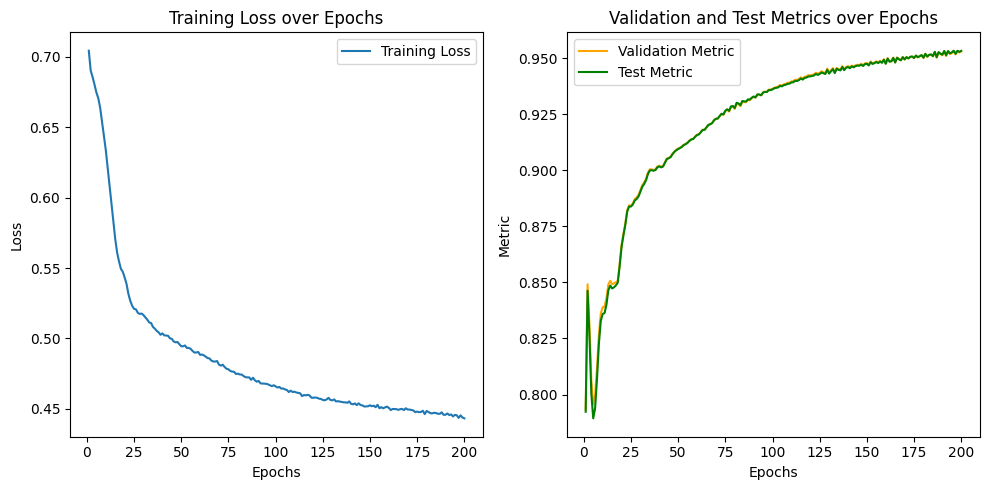

In [458]:
losses = [l.detach() for l in losses]
plot_curves({"train" : losses, "valid" : valid_aucs, "test" : test_aucs})

In [474]:
{"train" : losses, "valid" : valid_aucs, "test" : test_aucs}

{'train': [tensor(0.7045),
  tensor(0.6903),
  tensor(0.6858),
  tensor(0.6805),
  tensor(0.6749),
  tensor(0.6708),
  tensor(0.6641),
  tensor(0.6540),
  tensor(0.6445),
  tensor(0.6338),
  tensor(0.6211),
  tensor(0.6080),
  tensor(0.5958),
  tensor(0.5824),
  tensor(0.5707),
  tensor(0.5610),
  tensor(0.5547),
  tensor(0.5494),
  tensor(0.5473),
  tensor(0.5432),
  tensor(0.5386),
  tensor(0.5315),
  tensor(0.5266),
  tensor(0.5231),
  tensor(0.5209),
  tensor(0.5206),
  tensor(0.5181),
  tensor(0.5173),
  tensor(0.5176),
  tensor(0.5165),
  tensor(0.5148),
  tensor(0.5132),
  tensor(0.5113),
  tensor(0.5109),
  tensor(0.5081),
  tensor(0.5069),
  tensor(0.5053),
  tensor(0.5042),
  tensor(0.5025),
  tensor(0.5035),
  tensor(0.5021),
  tensor(0.5020),
  tensor(0.5018),
  tensor(0.5000),
  tensor(0.4996),
  tensor(0.4977),
  tensor(0.4972),
  tensor(0.4974),
  tensor(0.4958),
  tensor(0.4944),
  tensor(0.4944),
  tensor(0.4949),
  tensor(0.4931),
  tensor(0.4932),
  tensor(0.4924),
 

In [459]:
import torch
from torch_geometric.data import Data
from torch_geometric.utils import subgraph, is_undirected, to_undirected
import random

def split_graph(data):
    num_nodes = data.num_nodes
    start_node = random.randint(0, num_nodes - 1)

    visited = set([start_node])
    current = start_node

    while len(visited) < split_size:
        neighbors = data.edge_index[1, data.edge_index[0] == current]
        if len(neighbors) == 0:  # If no neighbors, pick a random node
            current = random.randint(0, num_nodes - 1)
        else:
            current = neighbors[random.randint(0, len(neighbors) - 1)].item()
        visited.add(current)

    # Nodes for the first subgraph
    nodes_1 = torch.tensor(list(visited), dtype=torch.long)
    node_mask_1 = torch.zeros(num_nodes, dtype=torch.bool).scatter_(0, nodes_1, True)

    # Nodes for the second subgraph
    nodes_2 = torch.tensor([n for n in range(num_nodes) if n not in visited], dtype=torch.long)
    node_mask_2 = torch.zeros(num_nodes, dtype=torch.bool).scatter_(0, nodes_2, True)

    # Create subgraphs
    subgraph_1_edge_index, _ = subgraph(nodes_1, data.edge_index)
    subgraph_2_edge_index, _ = subgraph(nodes_2, data.edge_index)

    # Identify removed (interconnecting) edges
    edge_mask = node_mask_1[data.edge_index[0]] & node_mask_2[data.edge_index[1]]
    removed_edges = data.edge_index[:, edge_mask]

    # Create new Data objects
    data_1 = Data(x=data.x[nodes_1], edge_index=subgraph_1_edge_index)
    data_2 = Data(x=data.x[nodes_2], edge_index=subgraph_2_edge_index)

    return data_1, data_2, removed_edges

In [460]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class LinkPredictionModel(nn.Module):
    def __init__(self, embedding_dim, hidden_dim):
        super(LinkPredictionModel, self).__init__()
        self.fc1 = nn.Linear(2 * embedding_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, 1)
        self.act = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, node_emb_1, node_emb_2):
        # Concatenate the two node embeddings
        x = torch.cat([node_emb_1, node_emb_2], dim=1)
        x = self.fc1(x)
        x = self.act(x)
        x = self.fc2(x)
        x = self.sigmoid(x)
        return x

In [461]:
def pred_train(model, data, embs, optimizer, criterion):
    model.train()
    loss = 0
    
    optimizer.zero_grad()

    negative_edges = negative_sampling(
      edge_index=data.edge_label_index,  # positive edges in the graph
      num_nodes=data.num_nodes,  # number of nodes
      num_neg_samples=len(data.edge_label_index[0]),  # number of negative examples
    ) # 4

    all_edges = torch.cat((data.edge_label_index, negative_edges), 1) # 5

    all_labels = torch.cat((data.edge_label, data.edge_label-1)) # 6
    
    predictions = model(embs[all_edges[0]], embs[all_edges[1]]).squeeze()

    loss = criterion(predictions, all_labels)
    loss.backward()
    optimizer.step()

    return loss

In [462]:
train_node_embs = emb_model(wikics_train.x, wikics_train.edge_index).detach()

In [463]:
train_node_embs.shape

torch.Size([11701, 64])

In [485]:
pred_model = LinkPredictionModel(train_node_embs.shape[1], 64)
optimizer = torch.optim.Adam(pred_model.parameters(), lr=0.001)
criterion = nn.BCELoss()

In [486]:
num_epochs = 1000
ls = []
for epoch in range(num_epochs):
    loss = pred_train(pred_model, wikics_train, train_node_embs, optimizer, criterion)
    ls.append(loss)
    print(f"Epoch {epoch+1}, Loss: {loss:.4f}")

Epoch 1, Loss: 0.6931
Epoch 2, Loss: 0.6867
Epoch 3, Loss: 0.6805
Epoch 4, Loss: 0.6745
Epoch 5, Loss: 0.6687
Epoch 6, Loss: 0.6633
Epoch 7, Loss: 0.6578
Epoch 8, Loss: 0.6525
Epoch 9, Loss: 0.6474
Epoch 10, Loss: 0.6423
Epoch 11, Loss: 0.6374
Epoch 12, Loss: 0.6328
Epoch 13, Loss: 0.6284
Epoch 14, Loss: 0.6237
Epoch 15, Loss: 0.6192
Epoch 16, Loss: 0.6152
Epoch 17, Loss: 0.6110
Epoch 18, Loss: 0.6070
Epoch 19, Loss: 0.6029
Epoch 20, Loss: 0.5991
Epoch 21, Loss: 0.5957
Epoch 22, Loss: 0.5925
Epoch 23, Loss: 0.5890
Epoch 24, Loss: 0.5851
Epoch 25, Loss: 0.5817
Epoch 26, Loss: 0.5789
Epoch 27, Loss: 0.5747
Epoch 28, Loss: 0.5712
Epoch 29, Loss: 0.5684
Epoch 30, Loss: 0.5647
Epoch 31, Loss: 0.5616
Epoch 32, Loss: 0.5582
Epoch 33, Loss: 0.5541
Epoch 34, Loss: 0.5507
Epoch 35, Loss: 0.5469
Epoch 36, Loss: 0.5434
Epoch 37, Loss: 0.5401
Epoch 38, Loss: 0.5353
Epoch 39, Loss: 0.5323
Epoch 40, Loss: 0.5288
Epoch 41, Loss: 0.5243
Epoch 42, Loss: 0.5210
Epoch 43, Loss: 0.5172
Epoch 44, Loss: 0.51

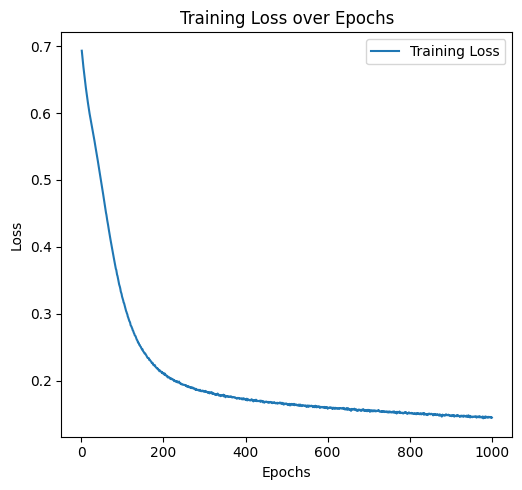

In [487]:
ls = [l.detach() for l in ls]
def plot_curvess(curves):
    epochs = range(1, len(curves["train"]) + 1)

    plt.figure(figsize=(10, 5))

    # Plot training loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, curves["train"], label='Training Loss')
    plt.title('Training Loss over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    # plt.xticks(epochs)
    plt.legend()

    plt.tight_layout()
    plt.show()
plot_curvess({"train" : ls})

In [488]:
def acc(model, data):
    model.eval()
    embs = emb_model(data.x, data.edge_index).detach()
    predictions = model(embs[data.edge_label_index[0]], embs[data.edge_label_index[1]]).squeeze() > 0.5
    labels = data.edge_label.type(torch.bool)
    both_true = (predictions & labels).sum()
    both_false = (~(predictions | labels)).sum()

    return (both_true + both_false) / len(predictions)

In [489]:
acc(pred_model, wikics_test)

tensor(0.9272)

In [490]:
def combine_graphs(emb_model, pred_model, whole, sg1, sg2, crossing_edges):
    sg1_embs = emb_model(whole.x, sg1.edge_index).detach()
    sg2_embs = emb_model(whole.x, sg2.edge_index).detach()
    
    negative_edges = negative_sampling(
      edge_index=crossing_edges,  # positive edges in the graph
      num_nodes=whole.x.shape[0],  # number of nodes
      num_neg_samples=len(crossing_edges[0]),  # number of negative examples
    ) # 4

    all_edges = torch.cat((crossing_edges, negative_edges), 1) # 5

    all_labels = torch.cat((torch.ones(len(crossing_edges[0])), torch.zeros(len(crossing_edges[0])))) # 6

    predictions = pred_model(sg1_embs[all_edges[0]], sg2_embs[all_edges[1]]).squeeze() > 0.5
    labels = all_labels.type(torch.bool)
    both_true = (predictions & labels).sum()
    both_false = (~(predictions | labels)).sum()
    false_neg_pos = (predictions ^ labels).sum()
    return (both_true + both_false) / len(predictions), both_true / (both_true + (1/2) * false_neg_pos)

In [491]:
sg1, sg2, crossing_edges = split_graph(wikics_test)
combine_graphs(emb_model, pred_model, wikics_test, sg1, sg2, crossing_edges)

(tensor(0.7735), tensor(0.7108))